# Clase 4:	Portafolios y riesgo

[Juan Diego Sánchez Torres](https://www.researchgate.net/profile/Juan_Diego_Sanchez_Torres), 

*Profesor*, [MAF ITESO](http://maf.iteso.mx/web/general/detalle?group_id=5858156)

+ Departamento de Matemáticas y Física
+ dsanchez@iteso.mx
+ Tel. 3669-34-34 Ext. 3069
+ Oficina: Cubículo 4, Edificio J, 2do piso

# 1. Motivación

En primer lugar, para poder bajar precios y información sobre opciones de Yahoo, es necesario cargar algunos paquetes de Python. En este caso, el paquete principal será Pandas. También, se usarán el Scipy y el Numpy para las matemáticas necesarias y, el Matplotlib y el Seaborn para hacer gráficos de las series de datos.

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from datetime import datetime
import scipy.stats as stats
import scipy as sp
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def def_portafolio(tickers, participacion=None):
    if (participacion is None):
        part = np.ones(len(tickers))/len(tickers)    
    portfolio = pd.DataFrame({'Tickers': tickers, 'Participacion': participacion}, index=tickers)
    return portfolio

In [3]:
portafolio = def_portafolio(['Acción A', 'Acción B'], [1, 1])
portafolio

,Participacion,Tickers
Acción A,1,Acción A
Acción B,1,Acción B


In [4]:
rendimientos = pd.DataFrame({'Acción A': [0.1, 0.24, 0.05, -0.02, 0.2],
                             'Acción B': [-0.15, -0.2, -0.01, 0.04, -0.15]})
rendimientos

,Acción A,Acción B
0,0.10,-0.15
1,0.24,-0.20
2,0.05,-0.01
3,-0.02,0.04
4,0.20,-0.15


In [5]:
def valor_portafolio_ponderado(portafolio, rendimientos, name='Valor'):
    total_participacion = portafolio.Participacion.sum()
    ponderaciones=portafolio.Participacion/total_participacion
    rendimientos_ponderados = rendimientos*ponderaciones
    return pd.DataFrame({name: rendimientos_ponderados.sum(axis=1)})

In [6]:
rend_portafolio=valor_portafolio_ponderado(portafolio, rendimientos, 'Valor')
rend_portafolio

,Valor
0,-0.025
1,0.020
2,0.020
3,0.010
4,0.025


In [7]:
total_rend=pd.concat([rendimientos, rend_portafolio], axis=1)
total_rend

,Acción A,Acción B,Valor
0,0.10,-0.15,-0.025
1,0.24,-0.20,0.020
2,0.05,-0.01,0.020
3,-0.02,0.04,0.010
4,0.20,-0.15,0.025


In [8]:
total_rend.std()

Acción A    0.107
Acción B    0.103
Valor       0.020
dtype: float64

In [9]:
rendimientos.corr()

,Acción A,Acción B
Acción A,1.000,-0.926
Acción B,-0.926,1.000


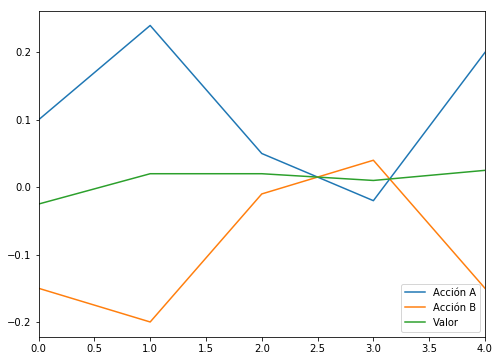

In [10]:
total_rend.plot(figsize=(8,6));

In [11]:
def plot_portafolio_rend(rend, title=None):
    rend.plot(figsize=(8,6))
    plt.xlabel('Año')
    plt.ylabel('Rendimientos')
    if (title is not None): plt.title(title)
    plt.show()

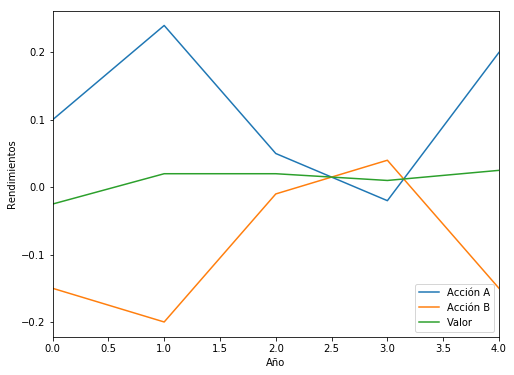

In [12]:
plot_portafolio_rend(total_rend);

# 2. Uso de Pandas para descargar datos de precios de cierre

Ahora, en forma de función

In [13]:
def get_historical_closes(ticker, start_date, end_date):
    p = web.DataReader(ticker, "yahoo", start_date, end_date).sort_index('major_axis')
    d = p.to_frame()['Adj Close'].reset_index()
    d.rename(columns={'minor': 'Ticker', 'Adj Close': 'Close'}, inplace=True)
    pivoted = d.pivot(index='Date', columns='Ticker')
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

Una vez cargados los paquetes, es necesario definir los tickers de las acciones que se usarán, la fuente de descarga (Yahoo en este caso, pero también se puede desde Google) y las fechas de interés. Con esto, la función *DataReader* del paquete *pandas_datareader* bajará los precios solicitados.

**Nota**: Usualmente, las distribuciones de Python no cuentan, por defecto, con el paquete *pandas_datareader*. Por lo que será necesario instalarlo aparte. El siguiente comando instala el paquete en Anaconda:
*conda install -c conda-forge pandas-datareader *

In [14]:
closes=get_historical_closes(['AA','AAPL','MSFT','KO'], '2010-01-01', '2016-12-31')
closes

Ticker,AA,AAPL,KO,MSFT
Date,,,,
2010-01-04,37.019,27.505,22.734,25.275
2010-01-05,35.863,27.553,22.459,25.283
2010-01-06,37.730,27.114,22.451,25.128
2010-01-07,36.930,27.064,22.395,24.867
2010-01-08,37.842,27.244,21.981,25.038
...,...,...,...,...
2016-12-23,29.710,115.088,40.899,62.169
2016-12-27,29.650,115.819,40.909,62.209
2016-12-28,29.430,115.325,40.693,61.924


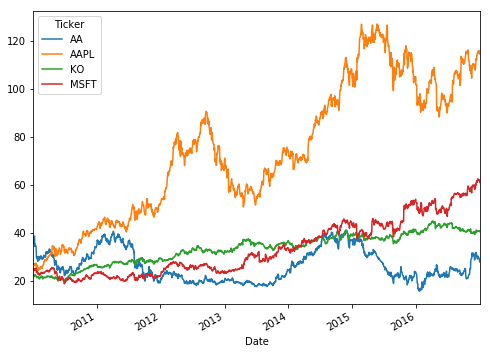

In [15]:
closes.plot(figsize=(8,6));

**Nota**: Para descargar datos de la bolsa mexicana de valores (BMV), el ticker debe tener la extensión MX. 
Por ejemplo: *MEXCHEM.MX*, *LABB.MX*, *GFINBURO.MX* y *GFNORTEO.MX*.

# 3. Formulación del riesgo de un portafolio

In [16]:
def calc_daily_returns(closes):
    return np.log(closes/closes.shift(1))[1:]

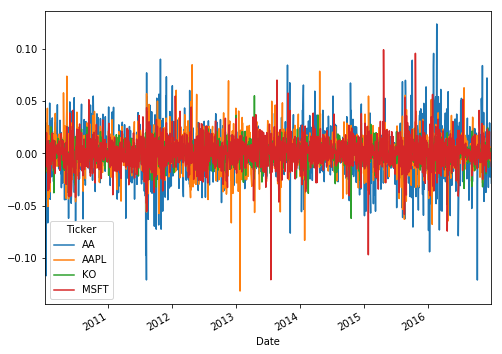

In [17]:
daily_returns=calc_daily_returns(closes)
daily_returns.plot(figsize=(8,6));

In [18]:
daily_returns.corr()

Ticker,AA,AAPL,KO,MSFT
Ticker,,,,
AA,1.000,0.343,0.344,0.395
AAPL,0.343,1.000,0.293,0.395
KO,0.344,0.293,1.000,0.408
MSFT,0.395,0.395,0.408,1.000


In [19]:
def calc_annual_returns(daily_returns):
    grouped = np.exp(daily_returns.groupby(lambda date: date.year).sum())-1
    return grouped

In [20]:
annual_returns = calc_annual_returns(daily_returns)
annual_returns

Ticker,AA,AAPL,KO,MSFT
2010,-0.067,0.507,0.189,-0.079
2011,-0.433,0.256,0.095,-0.045
2012,0.017,0.326,0.065,0.058
2013,0.241,0.081,0.172,0.443
2014,0.498,0.406,0.053,0.276
2015,-0.368,-0.030,0.051,0.227
2016,0.201,0.125,-0.004,0.151


In [21]:
def calc_portfolio_var(returns, weights=None):
    if (weights is None):
        weights = np.ones(returns.columns.size)/returns.columns.size
    sigma = np.cov(returns.T,ddof=0)
    var = (weights * sigma * weights.T).sum()
    return var

In [22]:
calc_portfolio_var(annual_returns)

0.013488788107574846

In [23]:
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.015):
    n = returns.columns.size
    if weights is None: weights = np.ones(n)/n
    var = calc_portfolio_var(returns, weights)
    means = returns.mean()
    return (means.dot(weights) - risk_free_rate)/np.sqrt(var)

In [24]:
sharpe_ratio(annual_returns)

0.91958164865210668

# 4. Optimización de portafolios

In [25]:
def f(x): return 2+x**2

In [26]:
scopt.fmin(f, 10)

Optimization terminated successfully.
         Current function value: 2.000000
         Iterations: 21
         Function evaluations: 42


array([ 0.])

In [27]:
def negative_sharpe_ratio_n_minus_1_stock(weights,returns,risk_free_rate):
    """
    Given n-1 weights, return a negative sharpe ratio
    """
    weights2 = sp.append(weights, 1-np.sum(weights))
    return -sharpe_ratio(returns, weights2, risk_free_rate)

In [28]:
def optimize_portfolio(returns, risk_free_rate):
    w0 = np.ones(returns.columns.size-1, dtype=float) * 1.0 / returns.columns.size
    w1 = scopt.fmin(negative_sharpe_ratio_n_minus_1_stock, w0, args=(returns, risk_free_rate))
    final_w = sp.append(w1, 1 - np.sum(w1))
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)
    return (final_w, final_sharpe)

In [29]:
optimize_portfolio(annual_returns, 0.0003)

Optimization terminated successfully.
         Current function value: -1.936823
         Iterations: 69
         Function evaluations: 125


(array([ 0.00325122,  0.27199186,  0.59407108,  0.13068584]),
 1.9368230810921603)

In [30]:
def objfun(W, R, target_ret):
    stock_mean = np.mean(R,axis=0)
    port_mean = np.dot(W,stock_mean)
    cov=np.cov(R.T)
    port_var = np.dot(np.dot(W,cov),W.T)
    penalty = 2000*abs(port_mean-target_ret)
    return np.sqrt(port_var) + penalty

In [31]:
def calc_efficient_frontier(returns):
    result_means = []
    result_stds = []
    result_weights = []
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    nstocks = returns.columns.size
    for r in np.linspace(min_mean, max_mean, 150):
        weights = np.ones(nstocks)/nstocks
        bounds = [(0,1) for i in np.arange(nstocks)]
        constraints = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1})
        results = scopt.minimize(objfun, weights, (returns, r), method='SLSQP', constraints = constraints, bounds = bounds)
        if not results.success: # handle error
            raise Exception(result.message)
        result_means.append(np.round(r,4)) # 4 decimal places
        std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)
        result_stds.append(std_)
        result_weights.append(np.round(results.x, 5))
    return {'Means': result_means, 'Stds': result_stds, 'Weights': result_weights}

In [32]:
frontier_data = calc_efficient_frontier(annual_returns)

In [33]:
def plot_efficient_frontier(ef_data):
    plt.figure(figsize=(12,8))
    plt.title('Efficient Frontier')
    plt.xlabel('Standard Deviation of the porfolio (Risk))')
    plt.ylabel('Return of the portfolio')
    plt.plot(ef_data['Stds'], ef_data['Means'], '--');

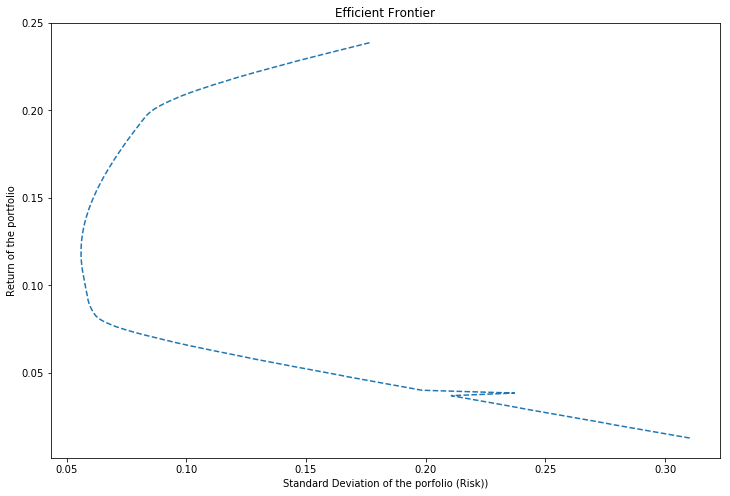

In [34]:
plot_efficient_frontier(frontier_data)

# 5. ETF

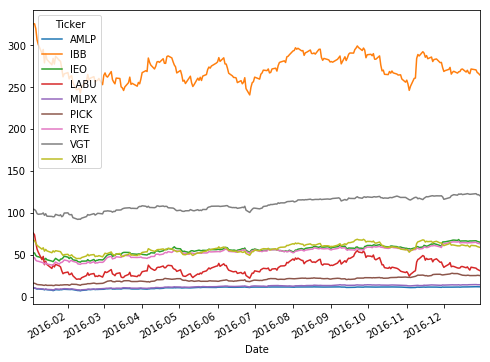

In [35]:
etf=get_historical_closes(['PICK','IBB','XBI','MLPX','AMLP','VGT','RYE','IEO','LABU'], '2016-01-01', '2016-12-31')
etf.plot(figsize=(8,6));

In [36]:
daily_returns_etf=calc_daily_returns(etf)
daily_returns_etf

Ticker,AMLP,IBB,IEO,...,RYE,VGT,XBI
Date,,,,,,,
2016-01-05,-6.601e-03,2.754e-04,2.644e-03,...,-0.003,-4.795e-03,-0.009
2016-01-06,-5.882e-02,-1.802e-02,-5.905e-02,...,-0.064,-1.366e-02,-0.044
2016-01-07,-5.504e-02,-4.243e-02,-2.348e-02,...,-0.024,-3.273e-02,-0.040
2016-01-08,1.929e-02,-1.830e-02,-7.195e-03,...,-0.005,-8.626e-03,-0.021
2016-01-11,-5.518e-02,-3.540e-02,-3.080e-02,...,-0.033,4.868e-03,-0.057
...,...,...,...,...,...,...,...
2016-12-23,5.518e-03,2.085e-02,-8.977e-04,...,0.000,1.381e-03,0.034
2016-12-27,-7.863e-04,-3.900e-03,3.884e-03,...,0.008,5.021e-03,-0.009
2016-12-28,-4.732e-03,-1.179e-02,-1.230e-02,...,-0.017,-1.007e-02,-0.014


In [47]:
daily_returns_etf_mean=daily_returns_etf.mean()
daily_returns_etf_mean

Ticker
AMLP    5.180e-04
IBB    -8.229e-04
IEO     8.932e-04
LABU   -3.537e-03
MLPX    1.185e-03
PICK    1.815e-03
RYE     1.215e-03
VGT     5.763e-04
XBI    -5.317e-04
dtype: float64

In [38]:
daily_returns_etf_std=daily_returns_etf.std()
daily_returns_etf_std

Ticker
AMLP    0.022
IBB     0.019
IEO     0.021
LABU    0.074
MLPX    0.022
PICK    0.022
RYE     0.021
VGT     0.010
XBI     0.025
dtype: float64

In [48]:
daily_returns_ms=pd.concat([daily_returns_etf_mean, daily_returns_etf_std], axis=1)
daily_returns_ms

,0,1
Ticker,,
AMLP,5.180e-04,0.022
IBB,-8.229e-04,0.019
IEO,8.932e-04,0.021
LABU,-3.537e-03,0.074
MLPX,1.185e-03,0.022
PICK,1.815e-03,0.022
RYE,1.215e-03,0.021
VGT,5.763e-04,0.010
XBI,-5.317e-04,0.025


In [49]:
from sklearn.cluster import KMeans

In [41]:
random_state = 10
y_pred = KMeans(n_clusters=5, random_state=random_state).fit_predict(daily_returns_ms)

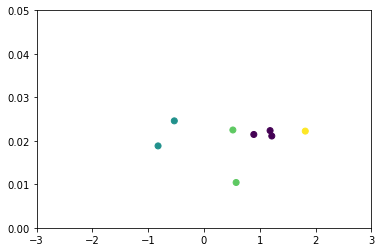

In [42]:
plt.scatter(daily_returns_etf_mean, daily_returns_etf_std, c=y_pred);
plt.axis([-3, 3, 0, 0.05]);

In [43]:
import scipy.cluster.hierarchy as hac

In [44]:
corr_mat=daily_returns_etf.corr(method='spearman')
corr_mat

Ticker,AMLP,IBB,IEO,...,RYE,VGT,XBI
Ticker,,,,,,,
AMLP,1.000,0.308,0.706,...,0.740,0.358,0.316
IBB,0.308,1.000,0.371,...,0.348,0.543,0.954
IEO,0.706,0.371,1.000,...,0.967,0.476,0.353
LABU,0.313,0.952,0.349,...,0.338,0.534,0.998
MLPX,0.894,0.356,0.839,...,0.866,0.441,0.338
PICK,0.555,0.337,0.592,...,0.648,0.488,0.355
RYE,0.740,0.348,0.967,...,1.000,0.443,0.342
VGT,0.358,0.543,0.476,...,0.443,1.000,0.534
XBI,0.316,0.954,0.353,...,0.342,0.534,1.000


In [45]:
Z = hac.linkage(corr_mat, 'single')

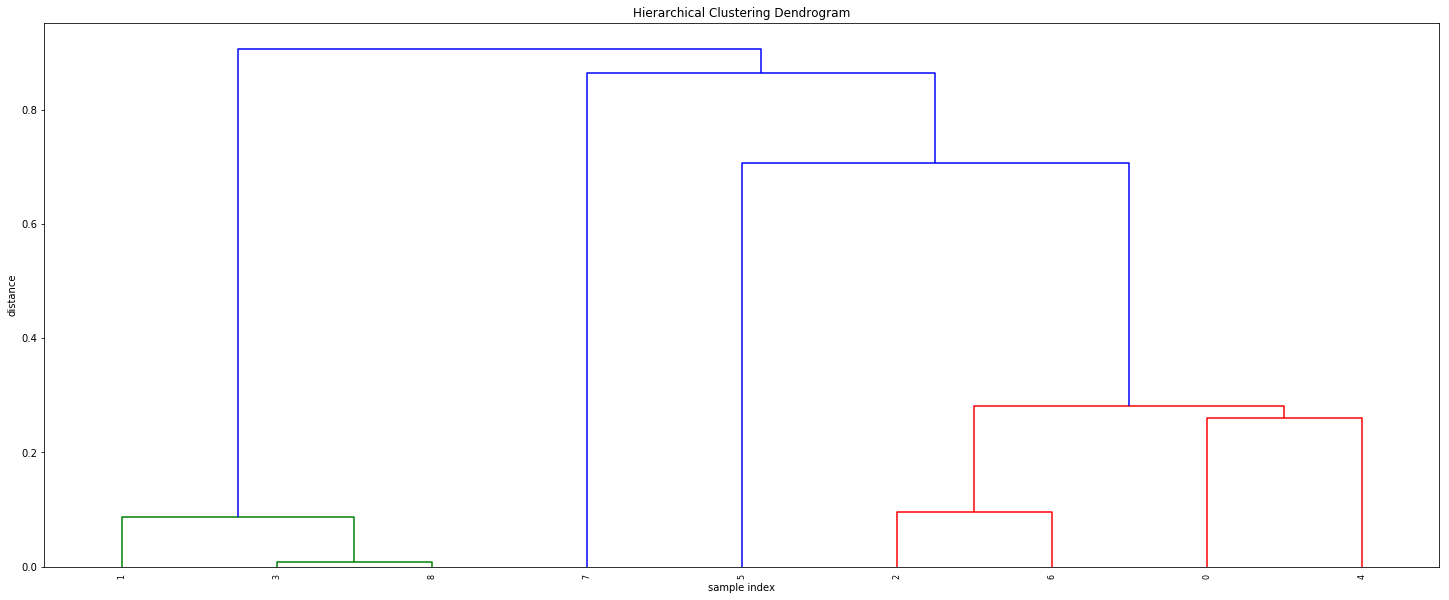

In [46]:
# Plot the dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()